# **Anime Recommendation System**

<hr>

**<h3> Import required libraries </h3>**

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import operator
import time
import math
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

<hr>

**<h3> Anime Dataset </h3>**

In [3]:
#Read and display dataset using Pandas
anime_dataset = pd.read_csv("../input/anime-recommendations-database/anime.csv",encoding ="latin-1")
display(anime_dataset.head())
print("Number of diffrent Anime Programs: ",anime_dataset.shape[0])
print("Number of features in the dataset: ",anime_dataset.shape[1],anime_dataset.columns.values)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Number of diffrent Anime Programs:  12294
Number of features in the dataset:  7 ['anime_id' 'name' 'genre' 'type' 'episodes' 'rating' 'members']


**<h4>Data Preprocessing</h4>**

In [4]:
print("Data type and Null Values: ")
display(anime_dataset.info())

print("\nStatistics about the dataset: ")
display(anime_dataset["rating"].describe())

Data type and Null Values: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


None


Statistics about the dataset: 


count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

In [5]:
#Drop all null values from the dataset
anime_dataset = anime_dataset.dropna()

#Change unknown "episode" values to 0.
anime_dataset.loc[anime_dataset["episodes"] == "Unknown", "episodes"] = 0
anime_dataset["episodes"] = anime_dataset["episodes"].astype(int)

<hr>

**<h3> Rating Dataset </h3>**

In [6]:
rating_dataset = pd.read_csv("../input/anime-recommendations-database/rating.csv")
display(rating_dataset.head())
print("Number of entries in the dataset: ",rating_dataset.shape[0])
print("Number of features in the dataset: ",rating_dataset.shape[1])
print("The features are: ",rating_dataset.columns.values)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Number of entries in the dataset:  7813737
Number of features in the dataset:  3
The features are:  ['user_id' 'anime_id' 'rating']


<hr>

**<h3>Final Dataset</h3>**

We will now merge the two datasets "anime_dataset" and "rating_dataset" and create a new dataset "final_dataset" which will be used to train our DM/ML models.

In [7]:
final_dataset = pd.merge(anime_dataset,rating_dataset[["user_id","anime_id","rating"]], on = ["anime_id"],how = "right")
final_dataset.rename(columns = {'rating_x':'AverageRating','rating_y':'rating'}, inplace = True)
#Drop rows with null Average Rating
final_dataset.dropna(inplace=True)

print("Final Dataset: ")
display(final_dataset.head(10))

Final Dataset: 


,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297.0,1,-1
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26.0,8.06,178553.0,1,-1
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24.0,7.31,158772.0,1,-1
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511.0,1,-1
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11.0,6.69,84395.0,1,-1
5,355,Shakugan no Shana,"Action, Drama, Fantasy, Romance, School, Super...",TV,24.0,7.74,297058.0,1,-1
6,356,Fate/stay night,"Action, Fantasy, Magic, Romance, Supernatural",TV,24.0,7.58,374880.0,1,-1
7,442,Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shin...,"Adventure, Comedy, Drama, Historical, Shounen,...",Movie,1.0,7.17,120571.0,1,-1
8,487,Girls Bravo: Second Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,13.0,6.90,57110.0,1,-1
9,846,School Rumble Ni Gakki,"Comedy, Romance, School, Shounen",TV,26.0,8.15,93095.0,1,-1


,index,anime_id,name,genre,AverageRating
0,8795,23005,Mogura no Motoro,Slice of Life,9.50
1,10747,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37
2,3965,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26
3,9831,28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25
4,9499,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",9.25
5,5673,9253,Steins;Gate,"Sci-Fi, Thriller",9.17
6,5997,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16
7,10935,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",9.15
8,6465,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",9.13
9,7249,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",9.11


,index,anime_id,name,genre,AverageRating
11152,10784,32388,Undouki Kenshin Manual Taiou Taisou,Kids,2.72
11153,10051,29949,Nami,Dementia,2.67
11154,10573,31634,Kokuhaku,Horror,2.67
11155,9087,24259,Mechano: Scientific Attack Force,"Comedy, Dementia, Fantasy, Horror, Music, Parody",2.55
11156,7166,14781,Roboteuwang Sseonsyakeu,"Action, Mecha, Sci-Fi",2.49
11157,385,413,Hametsu no Mars,"Horror, Sci-Fi",2.37
11158,6960,13405,Utsu Musume Sayuri,"Comedy, Dementia",2.14
11159,2929,3287,Tenkuu Danzai Skelter+Heaven,"Mecha, Sci-Fi",2.00
11160,8188,20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",1.92
11161,11160,34476,Platonic Chain: Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life",1.67


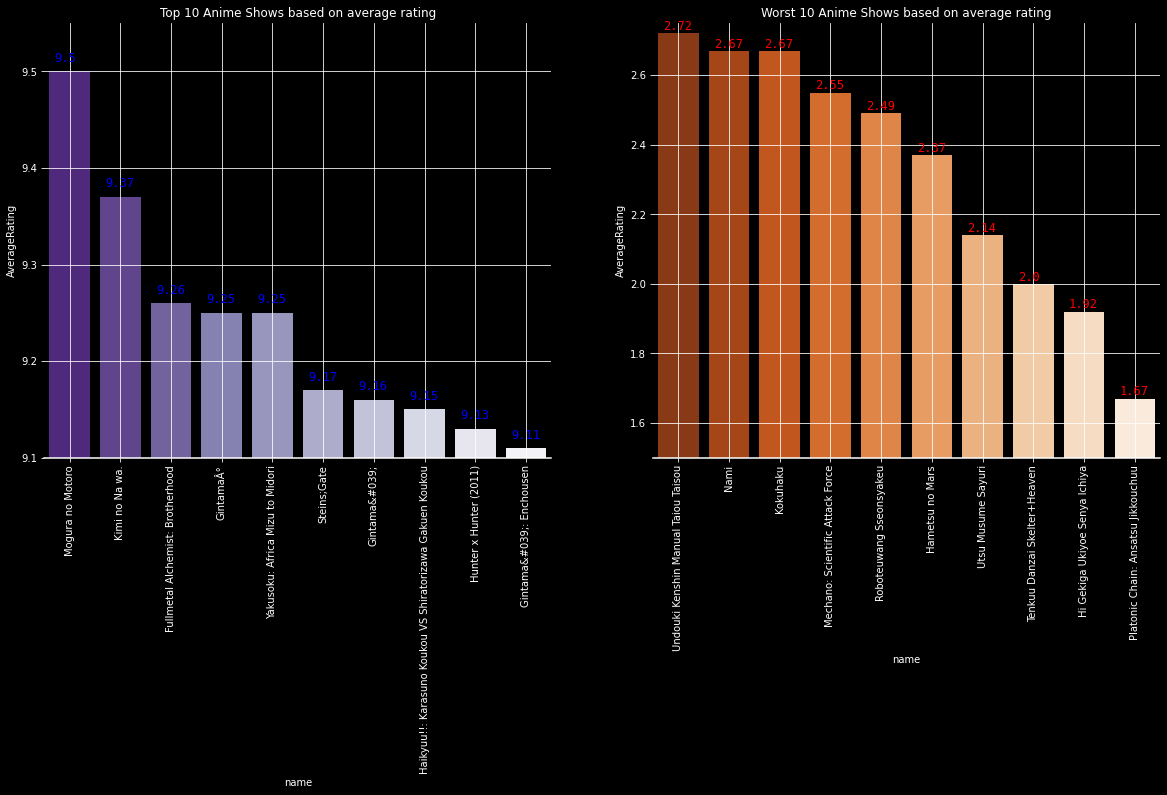

In [91]:
#Average Rating of each Anime
grouped_by_anime_id = final_dataset.groupby(["anime_id","name","genre"])[["AverageRating"]].mean().reset_index()
sorted_grouped_by_anime_id = grouped_by_anime_id.sort_values(by = ["AverageRating"],ascending=False).reset_index()

#Plot top 10 based on average rating of each show.
display(sorted_grouped_by_anime_id.head(10))
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
A = sns.barplot(sorted_grouped_by_anime_id.name[:10], sorted_grouped_by_anime_id["AverageRating"][:10], palette ="Purples_r")
A.spines['bottom'].set_linewidth(1.5)
for w in ['right', 'top', 'left']:
    A.spines[w].set_visible(False)
plt.title("Top 10 Anime Shows based on average rating")
plt.ylim(9.1,9.55)
plt.xticks(rotation=90)
plt.grid()

k=0
for p in A.patches:
    height = p.get_height()
    plt.text(p.get_x()+0.1,height+0.01, sorted_grouped_by_anime_id["AverageRating"][k],fontname = 'monospace', fontsize = 12, color = 'Blue') 
    k+=1


#Plot worst 10 anime shows based on average ratings
display(sorted_grouped_by_anime_id.tail(10))
plt.subplot(1, 2, 2)
B = sns.barplot(sorted_grouped_by_anime_id.name[11152:11162],sorted_grouped_by_anime_id["AverageRating"][11152:11162],palette="Oranges_r")
B.spines['bottom'].set_linewidth(1.5)
for w in ['right', 'top', 'left']:
    B.spines[w].set_visible(False)
    
k=11152
for p in B.patches:
    height = p.get_height()
    plt.text(p.get_x()+0.1,height+0.01, sorted_grouped_by_anime_id["AverageRating"][k],fontname = 'monospace', fontsize = 12, color = 'Red') 
    k+=1
plt.title("Worst 10 Anime Shows based on average rating")
plt.ylim(1.5,2.75)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [87]:
import plotly.express as px

# Group data by anime ID, name, and genre and calculate the average rating
grouped_by_anime_id = final_dataset.groupby(["anime_id","name","genre"])[["AverageRating"]].mean().reset_index()

# Sort the data based on average rating
sorted_grouped_by_anime_id = grouped_by_anime_id.sort_values(by=["AverageRating"], ascending=False).reset_index()

# Top 10 anime shows based on average rating
top_10 = sorted_grouped_by_anime_id.head(10)

fig_top = px.bar(top_10, x="name", y="AverageRating", color="genre", color_discrete_sequence=px.colors.qualitative.Pastel)
fig_top.update_layout(
    title={
        'text': "Top 10 Anime Shows based on average rating",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(title='Anime Show'),
    yaxis=dict(title='Average Rating'),
    font=dict(color='#333333'),
    paper_bgcolor='#F2F2F2',
    plot_bgcolor='#F2F2F2',
)
fig_top.show()

# Bottom 10 anime shows based on average rating
bottom_10 = sorted_grouped_by_anime_id.tail(10)

fig_bottom = px.bar(bottom_10, x="name", y="AverageRating", color="genre", color_discrete_sequence=px.colors.qualitative.Dark2)
fig_bottom.update_layout(
    title={
        'text': "Bottom 10 Anime Shows based on average rating",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(title='Anime Show'),
    yaxis=dict(title='Average Rating'),
    font=dict(color='#333333'),
    paper_bgcolor='#F2F2F2',
    plot_bgcolor='#F2F2F2',
)
fig_bottom.show()


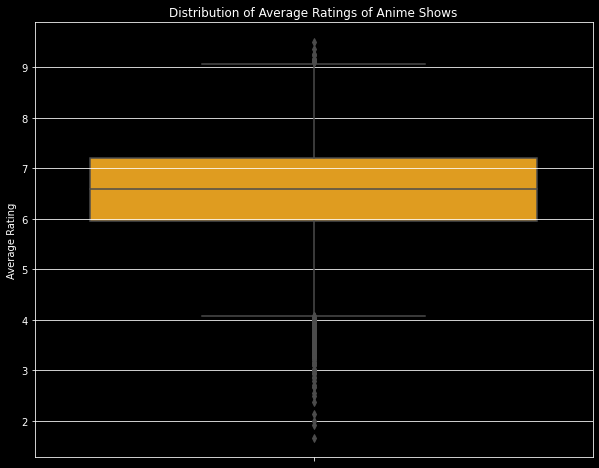

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by anime ID and calculate mean rating
grouped_by_anime_id = final_dataset.groupby(["anime_id", "name"])[["AverageRating"]].mean().reset_index()

# Plot boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(data=grouped_by_anime_id, y="AverageRating", color="orange")
plt.ylabel("Average Rating")
plt.title("Distribution of Average Ratings of Anime Shows")
plt.grid(axis="y")
plt.show()


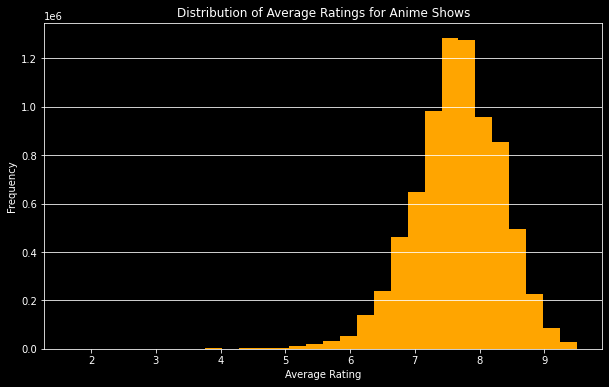

In [93]:
import matplotlib.pyplot as plt

# Select the average rating column from the dataset
average_rating = final_dataset["AverageRating"]

# Create the histogram
plt.figure(figsize=(10,6))
plt.hist(average_rating, bins=30, color="#FFA500")

# Add labels and titles
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Average Ratings for Anime Shows")

# Add grid lines
plt.grid(axis='y')

# Show the plot
plt.show()


- This shows that most average ratings are between 4 and 9 with 6-7 being the most dense area.
- There are many outliers in the data below 4 and more than 9

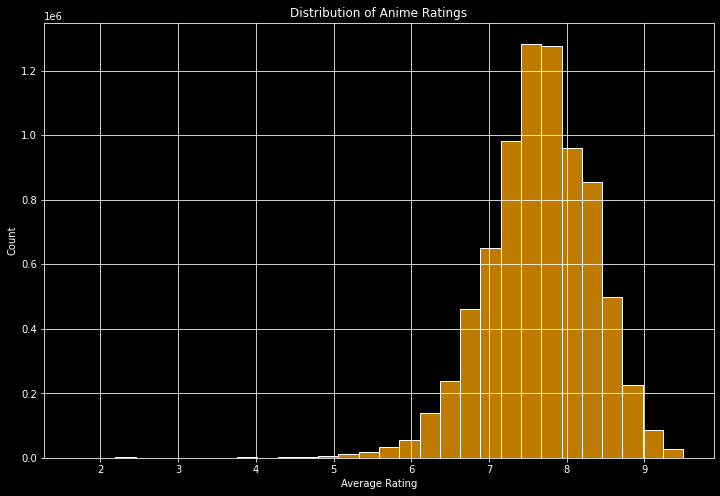

In [102]:
plt.figure(figsize=(12, 8))
sns.histplot(data=final_dataset, x="AverageRating", color="orange", bins=30)
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.title("Distribution of Anime Ratings")
plt.grid()
plt.show()


In [104]:
# Get the list of all genres
genres = final_dataset["genre"].str.cat(sep=",")

# Create a list of words from the genres
word_list = genres.lower().split()

# Create a dictionary with word frequency
word_freq = {}
for word in word_list:
    if word not in stopwords.words('english'):
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate_from_frequencies(word_freq)

# Plot the wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Anime Genres Wordcloud")
plt.show()


AttributeError: 'set' object has no attribute 'words'

<hr>

**4) Group the Anime based on "Type"**

In [103]:
anime_type = final_dataset["type"]
print("The different type of Anime Shows are: ",anime_type.unique())

labels = anime_type.value_counts().index
values = anime_type.value_counts().values

#Visualize the different types
colors = ['blue', 'mediumturquoise', 'orange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=10,textfont_color = "white",
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Types of Anime Shows",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        paper_bgcolor="black")

fig.show()

The different type of Anime Shows are:  ['TV' 'Movie' 'OVA' 'Special' 'ONA' 'Music']


In [80]:
import pandas as pd
import plotly.graph_objs as go

# Load dataset
final_dataset = pd.read_csv("anime_dataset.csv")

# Extract anime types
anime_type = final_dataset["type"]

# Count the number of anime shows in each type
type_counts = anime_type.value_counts()

# Define colors for each anime type
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe']

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=type_counts.index, 
                             values=type_counts.values,
                             hole=.4,
                             marker=dict(colors=colors))])

# Update the layout
fig.update_layout(title_text="Types of Anime Shows",
                  title_x=0.5,
                  paper_bgcolor="black",
                  font=dict(color="white"))

# Show the chart
fig.show()



FileNotFoundError: [Errno 2] No such file or directory: 'anime_dataset.csv'

In [83]:
import plotly.express as px

anime_type = final_dataset["type"]
labels = anime_type.value_counts().index
values = anime_type.value_counts().values

# Define a custom color palette
custom_colors = px.colors.qualitative.Pastel + px.colors.qualitative.Set2

fig = px.pie(values=values, names=labels, color_discrete_sequence=custom_colors)
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=14, 
                  marker=dict(line=dict(color='#FFFFFF', width=2)))

fig.update_layout(
    title={
        'text': "Types of Anime Shows",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    paper_bgcolor='#1E1E1E',
    plot_bgcolor='#1E1E1E',
)

fig.show()


In [82]:
import plotly.express as px

anime_type = final_dataset["type"]
labels = anime_type.value_counts().index
values = anime_type.value_counts().values

# Define a custom color palette
custom_colors = px.colors.qualitative.Pastel + px.colors.qualitative.Set2

fig = px.pie(values=values, names=labels, color_discrete_sequence=custom_colors)
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=14, 
                  marker=dict(line=dict(color='#FFFFFF', width=2)))

fig.update_layout(
    title={
        'text': "Types of Anime Shows",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    paper_bgcolor='#1E1E1E',
    plot_bgcolor='#1E1E1E',
)

fig.show()


Average Rating based on type: 
TV : 7.739
Movie : 7.81
Special : 7.331
OVA : 7.196
ONA : 7.053
Music : 7.033


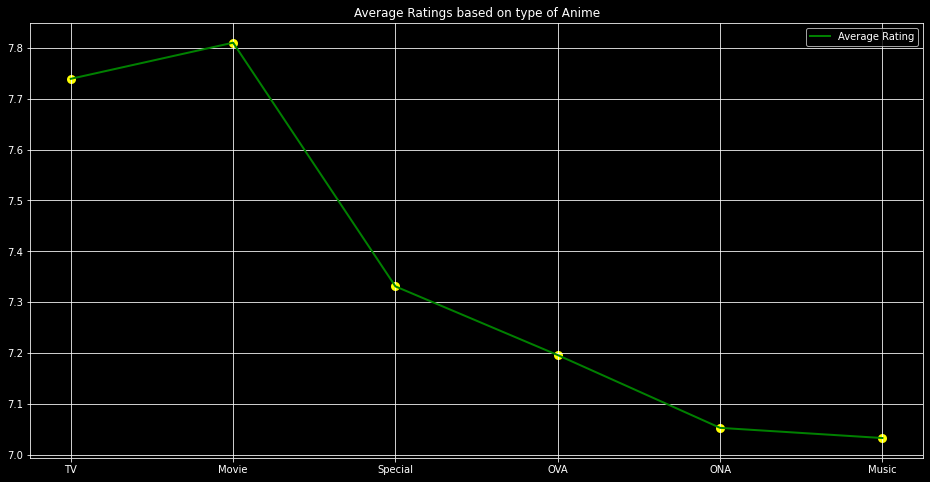

In [61]:
#Split dataset based on different types of anime
mean_avgrat_type = [round(final_dataset[final_dataset["type"] == "TV"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Movie"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Special"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "OVA"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "ONA"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Music"]["AverageRating"].mean(),3)]

labels = ["TV","Movie","Special","OVA","ONA","Music"]
print("Average Rating based on type: ")
for i in range(6):
    print(labels[i],":",mean_avgrat_type[i])
    
#Plot the average rating of every type.
plt.figure(figsize = (16,8))
plt.plot(["TV","Movie","Special","OVA","ONA","Music"],mean_avgrat_type,label = "Average Rating", c = "Green",linewidth = 2)
plt.scatter(labels,mean_avgrat_type, c = "Yellow",linewidth = 3)
plt.title("Average Ratings based on type of Anime")
plt.grid()
plt.legend()
plt.show()

<h3> Let's look at the top 100 Anime shows based on average rating </h3>

In [13]:
top_100_anime_shows = final_dataset.groupby(["anime_id","name","genre","episodes"])[["AverageRating"]].mean().reset_index()
sorted_top_100_anime_shows = top_100_anime_shows.sort_values(by = ["AverageRating"],ascending=False).reset_index()[:100]
display(sorted_top_100_anime_shows)

,index,anime_id,name,genre,episodes,AverageRating
0,8795,23005,Mogura no Motoro,Slice of Life,1.0,9.50
1,10747,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1.0,9.37
2,3965,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",64.0,9.26
3,9831,28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",51.0,9.25
4,9499,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",1.0,9.25
...,...,...,...,...,...,...
95,4381,5941,Cross Game,"Comedy, Drama, Romance, School, Sports",50.0,8.53
96,6026,10030,Bakuman. 2nd Season,"Comedy, Drama, Romance, Shounen",25.0,8.53
97,10201,30346,Doukyuusei (Movie),"Romance, School, Shounen Ai, Slice of Life",1.0,8.53
98,3273,3784,Evangelion: 2.0 You Can (Not) Advance,"Action, Mecha, Sci-Fi",1.0,8.53


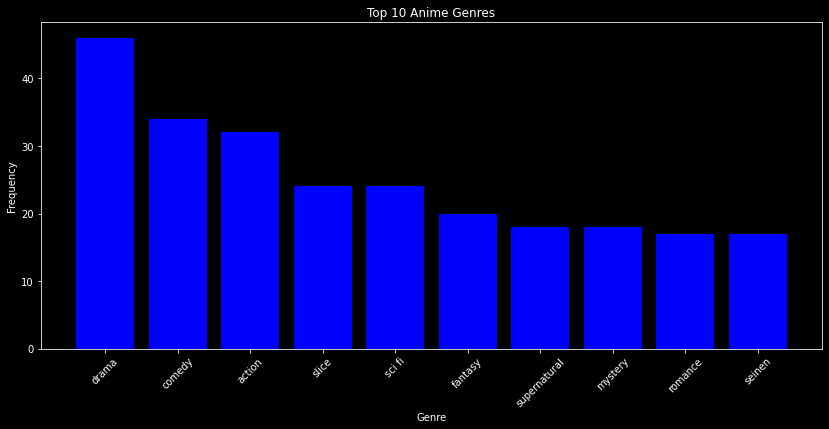

In [64]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

genres = sorted_top_100_anime_shows["genre"]

comment_words = ''
stopwords = set(STOPWORDS)

for genre in genres:
    genre = str(genre)
    # split the different genres
    tokens = genre.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=2000, height=1000, background_color='black', stopwords=stopwords, min_font_size=10).generate(comment_words)

# Get the frequency counts of each word
freqs = WordCloud(width=2000, height=1000, background_color='white', stopwords=stopwords, min_font_size=10).process_text(comment_words)

# Convert the frequency dictionary into a list of tuples, sorted by descending frequency
freq_list = sorted(freqs.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 most frequent words
top_words = [word for word, freq in freq_list[:10]]

# Extract the frequency values of the top words
top_freqs = [freq for word, freq in freq_list[:10]]

# Create a bar chart of the top words and their frequencies
fig, ax = plt.subplots()
ax.bar(top_words, top_freqs, color='blue')

# Set the title and axis labels
ax.set_title('Top 10 Anime Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the chart
plt.show()





In [16]:
clustering_data = final_dataset[:100000]
user_anime_crosstab = pd.crosstab(clustering_data['user_id'],clustering_data['name'])
user_anime_crosstab.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
#Apply Principle Component Analysis to reduce dimension of the data
pca = PCA(n_components=3)
pca.fit(user_anime_crosstab)
pca_samples = pca.transform(user_anime_crosstab)

ps = pd.DataFrame(pca_samples)
display(ps.head())

tocluster = pd.DataFrame(ps[[0,1,2]])

,0,1,2
0,3.104374,-4.178130,-0.767570
1,-2.757186,-0.711541,0.627841
2,0.288553,1.007548,0.784441
3,-0.952593,-0.316275,-0.648502
4,9.503828,-2.394918,-0.847191


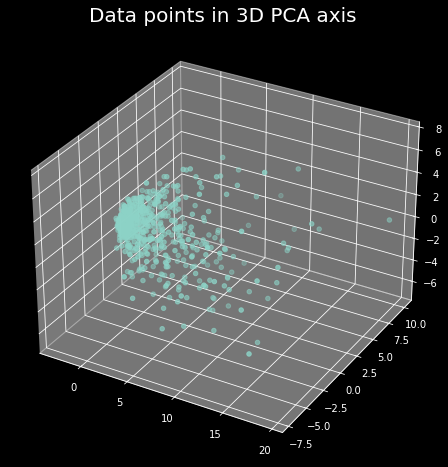

In [18]:
plt.rcParams['figure.figsize'] = (14, 6)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

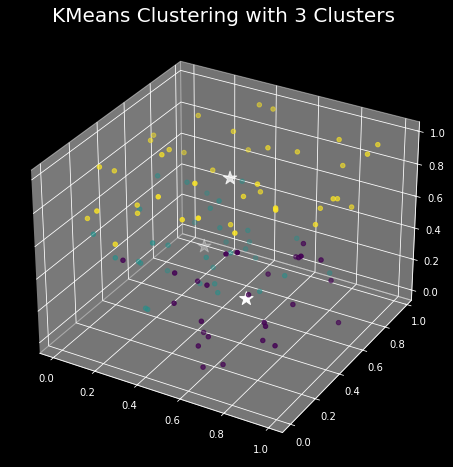

In [65]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate some sample data for clustering
np.random.seed(42)
tocluster = np.random.rand(100, 3)

# Define the number of clusters
n_clusters = 3

# Create a KMeans object with the specified number of clusters
kmeans = KMeans(n_clusters=n_clusters)

# Fit the KMeans model to the data
kmeans.fit(tocluster)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the data points with different colors for each cluster
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[:,0], tocluster[:,2], tocluster[:,1], c=labels, cmap='viridis')

# Plot the centroids as white stars
ax.scatter(centroids[:,0], centroids[:,2], centroids[:,1], marker='*', s=200, c='white')

plt.title(f'KMeans Clustering with {n_clusters} Clusters', fontsize=20)
plt.show()


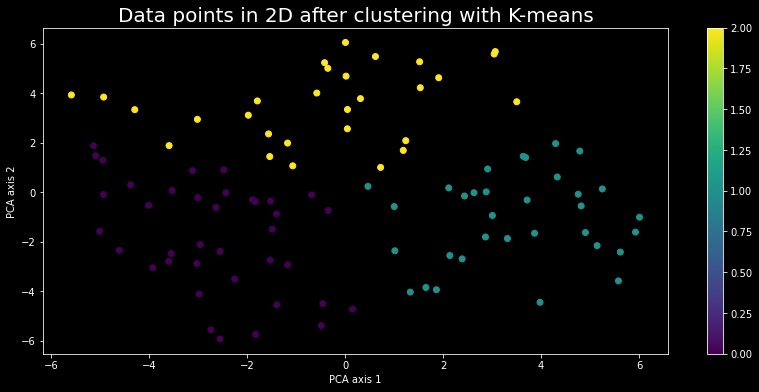

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 3) * 10

# Apply PCA to reduce data dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cluster data using K-means algorithm
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Plot clustered data in 2D
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)

# Plot cluster centroids in 2D
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='black')

# Set plot title and axis labels
plt.title('Data points in 2D after clustering with K-means', fontsize=20)
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')

# Show plot
plt.show()


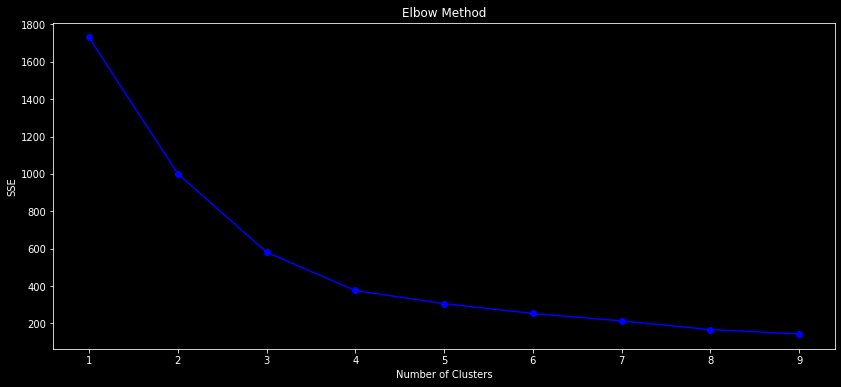

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 2) * 10

# Define range of number of clusters to test
k_range = range(1, 10)

# Initialize list to store sum of squared errors (SSE) for each k value
sse = []

# For each k value, fit K-means model and calculate SSE
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot SSE vs number of clusters
plt.plot(k_range, sse, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


In [71]:
#Build cluster model and fit data to it
clustering_model = KMeans(n_clusters=3,random_state=30)
clustering_model.fit(tocluster)

centers = clustering_model.cluster_centers_
c_preds = clustering_model.predict(tocluster)

print("Coordinates for the 3 clusters are: \n",centers)

Coordinates for the 3 clusters are: 
 [[0.28173968 0.24863325 0.65148532]
 [0.47280135 0.82072834 0.53872471]
 [0.72131332 0.37822615 0.24378945]]


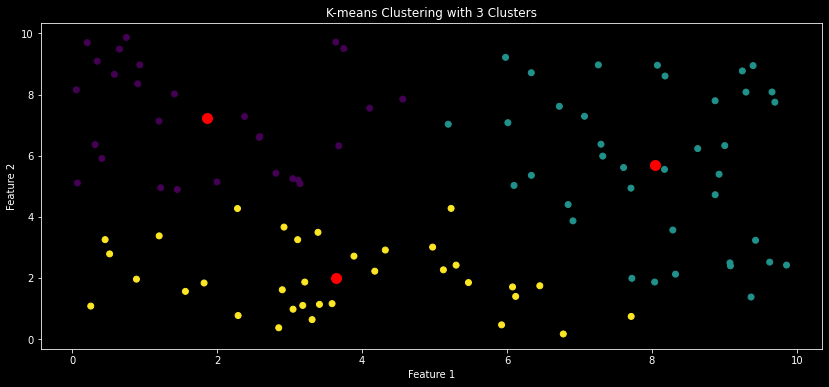

Coordinates for the 3 clusters are:
 [[1.85209431 7.22280654]
 [8.03963304 5.70269992]
 [3.63762484 2.00080429]]


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 2) * 10

# Fit K-means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster labels and centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Plot data points colored by cluster label
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100)
plt.title('K-means Clustering with 3 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
print("Coordinates for the 3 clusters are:\n", centers)


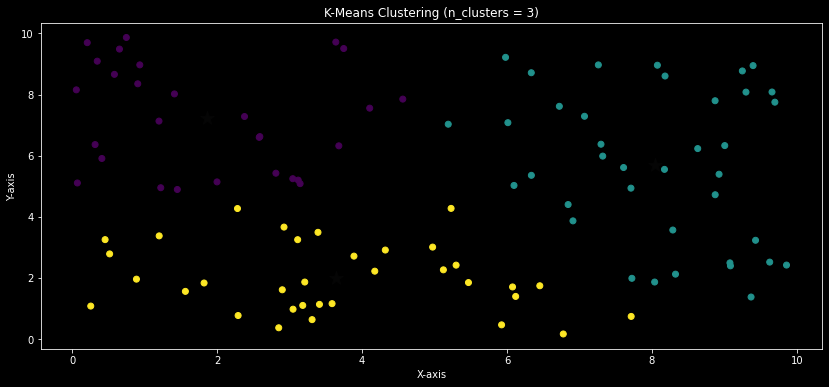

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 2) * 10

# Define number of clusters to use
n_clusters = 3

# Initialize KMeans model with specified number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Predict cluster labels for each data point
y_pred = kmeans.predict(X)

# Get coordinates of cluster centers
centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, c='#050505')
plt.title('K-Means Clustering (n_clusters = {})'.format(n_clusters))
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


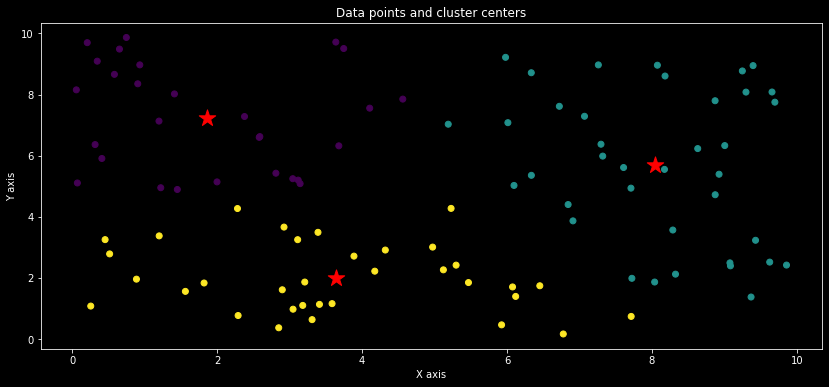

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 2) * 10

# Fit K-means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster centers and predicted cluster labels
centers = kmeans.cluster_centers_
c_preds = kmeans.predict(X)

# Plot data points and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=c_preds)
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=300, c='r')
plt.title('Data points and cluster centers')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


In [75]:
user_anime_crosstab['cluster'] = c_preds

c0 = user_anime_crosstab[user_anime_crosstab['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime_crosstab[user_anime_crosstab['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime_crosstab[user_anime_crosstab['cluster']==2].drop('cluster',axis=1).mean()

ValueError: Length of values (100) does not match length of index (1028)

In [74]:
import pandas as pd
from sklearn.cluster import KMeans

# Load data
anime_data = pd.read_csv('anime_data.csv')

# Select features to use for clustering
features = ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Romance', 'Sci-Fi', 'Thriller']
X = anime_data[features]

# Fit K-means model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Prompt user to enter their genre preferences
print('Please enter your preference score (0-10) for the following genres:')
user_prefs = []
for genre in features:
    pref = int(input(f'{genre}: '))
    user_prefs.append(pref)

# Convert user preferences to a dataframe row for clustering
user_df = pd.DataFrame([user_prefs], columns=features)

# Predict which cluster the user belongs to
user_cluster = kmeans.predict(user_df)

# Get the anime titles in the user's cluster
cluster_anime = anime_data.loc[kmeans.labels_ == user_cluster[0], 'Title']

# Recommend top 5 anime in the user's cluster
recommendations = cluster_anime.sample(5)

# Print recommendations
print('Based on your preferences, we recommend the following anime:')
for title in recommendations:
    print(title)


FileNotFoundError: [Errno 2] No such file or directory: 'anime_data.csv'

In [24]:
c1.sort_values(ascending=False)[0:15]

name
Death Note                          0.452830
Sword Art Online                    0.397678
Shingeki no Kyojin                  0.357039
Angel Beats!                        0.280116
Fullmetal Alchemist: Brotherhood    0.265602
Elfen Lied                          0.261248
Naruto                              0.251089
Mirai Nikki (TV)                    0.243832
Ao no Exorcist                      0.229318
Another                             0.224964
Highschool of the Dead              0.223512
Fullmetal Alchemist                 0.216255
Code Geass: Hangyaku no Lelouch     0.206096
Sen to Chihiro no Kamikakushi       0.203193
Ouran Koukou Host Club              0.198839
dtype: float64

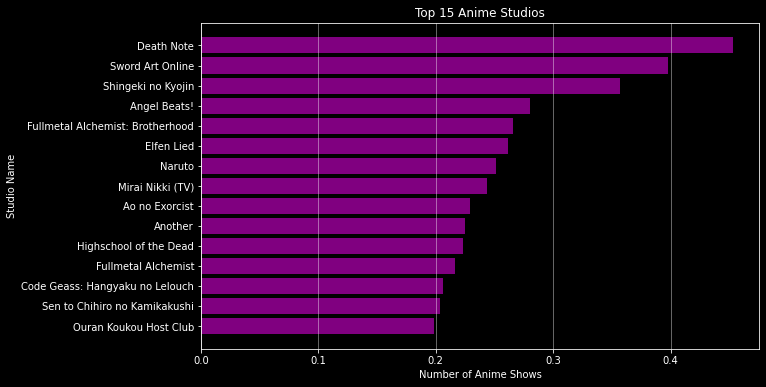

In [105]:
plt.figure(figsize=(10, 6))
plt.barh(c1.sort_values(ascending=False)[0:15].index, c1.sort_values(ascending=False)[0:15].values, color='purple')
plt.gca().invert_yaxis()
plt.title('Top 15 Anime Studios')
plt.xlabel('Number of Anime Shows')
plt.ylabel('Studio Name')
plt.grid(axis='x', alpha=0.5)
plt.show()
